# Modeling

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup 

import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


# Import Tokenizer
from nltk.tokenize import RegexpTokenizer

# Import Regular Expressions
import regex as re

from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Import model.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier 

from sklearn.svm import SVR, SVC

from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

from nltk.corpus import stopwords


%matplotlib inline

In [5]:
from warnings import catch_warnings
from warnings import filterwarnings
import warnings

warnings.simplefilter(action="ignore")

In [7]:
df = pd.read_csv('../datasets/df_IA_TX_WI_clean_adjusted.csv')
df.head()

,Unnamed: 0,Date,Favorites,HashTags,Mentions,Retweets,Text,location,target,user_split,user_text
0,0,2019-07-19 22:26:34+00:00,0,None,None,0,my dad just told me to flood my car so I can g...,WI,0,chaaasiti04,chaaasiti04 my dad just told me to flood my ca...
1,1,2019-07-19 22:19:05+00:00,1,None,None,2,"Happy B-day Reggie, from the office!!!",WI,0,JDenius,"JDenius Happy B-day Reggie, from the office!!!"
2,2,2019-07-19 22:17:13+00:00,0,None,None,0,Something about how crime will magically drop ...,WI,0,beganovic2021,beganovic2021 Something about how crime will m...
3,3,2019-07-19 20:57:18+00:00,0,None,None,0,Lol mine too. I’ve been avoiding floods for th...,WI,0,RiskItAllRichy,RiskItAllRichy Lol mine too. I’ve been avoidin...
4,4,2019-07-19 19:53:44+00:00,0,None,@RAGBRAI_IOWA,2,Riding the bus along I29 to @RAGBRAI_IOWA and ...,WI,1,CajunCy,CajunCy Riding the bus along I29 to @RAGBRAI_I...


In [8]:
# drop 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace = True)

In [9]:
df.head()

,Date,Favorites,HashTags,Mentions,Retweets,Text,location,target,user_split,user_text
0,2019-07-19 22:26:34+00:00,0,None,None,0,my dad just told me to flood my car so I can g...,WI,0,chaaasiti04,chaaasiti04 my dad just told me to flood my ca...
1,2019-07-19 22:19:05+00:00,1,None,None,2,"Happy B-day Reggie, from the office!!!",WI,0,JDenius,"JDenius Happy B-day Reggie, from the office!!!"
2,2019-07-19 22:17:13+00:00,0,None,None,0,Something about how crime will magically drop ...,WI,0,beganovic2021,beganovic2021 Something about how crime will m...
3,2019-07-19 20:57:18+00:00,0,None,None,0,Lol mine too. I’ve been avoiding floods for th...,WI,0,RiskItAllRichy,RiskItAllRichy Lol mine too. I’ve been avoidin...
4,2019-07-19 19:53:44+00:00,0,None,@RAGBRAI_IOWA,2,Riding the bus along I29 to @RAGBRAI_IOWA and ...,WI,1,CajunCy,CajunCy Riding the bus along I29 to @RAGBRAI_I...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 10 columns):
Date          3039 non-null object
Favorites     3039 non-null int64
HashTags      3039 non-null object
Mentions      3039 non-null object
Retweets      3039 non-null int64
Text          3039 non-null object
location      3039 non-null object
target        3039 non-null int64
user_split    3039 non-null object
user_text     3039 non-null object
dtypes: int64(3), object(7)
memory usage: 237.5+ KB


In [11]:
df['user_text']

0       chaaasiti04 my dad just told me to flood my ca...
1          JDenius Happy B-day Reggie, from the office!!!
2       beganovic2021 Something about how crime will m...
3       RiskItAllRichy Lol mine too. I’ve been avoidin...
4       CajunCy Riding the bus along I29 to @RAGBRAI_I...
                              ...                        
3034    DjRed ScrewedUp #Repost realierealind ・・・ @Ric...
3035    EddieMark718 Are you ready for #hurricanejose?...
3036    KennyBraunPhoto Post flood in the camp house. ...
3037     ms flood Drinking a Monoprint Oktoberfest by ...
3038     ms flood Drinking a Athena Paradiso (Tart Che...
Name: user_text, Length: 3039, dtype: object

## Preprocessing

In [12]:
# adapted from our NLP Lecture 5.03
def text_to_words(text):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [13]:
def stemmed_words(text):
    # Instantiate tokenizer.
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokenize text.
    tokens = tokenizer.tokenize(text.lower())
    # Instantiate stemmer.
    p_stemmer = PorterStemmer()
    # Stem words.
    stemmed_words = [p_stemmer.stem(word) for word in tokens]
    return stemmed_words

In [626]:
df[df['Text'].str.contains('&amp')].index

Int64Index([  40,   52,   59,   60,   76,   78,   94,   99,  103,  153,
            ...
            2858, 2873, 2887, 2888, 2895, 2906, 2929, 2980, 2982, 2990],
           dtype='int64', length=300)

In [627]:
df.replace({'&amp;': 'and'},  inplace=True, regex=True)

In [628]:
df['adj_text'] = [text_to_words(row) for row in df['Text']] 
df['adj_text_stem'] = [' '.join(stemmed_words(row)) for row in df['adj_text']]

In [630]:
df['target'].value_counts(normalize = True)

1    0.525831
0    0.474169
Name: target, dtype: float64

In [631]:
df.to_csv('df_concat_adjusted_stem.csv')

## Modeling

In [632]:
X = df['adj_text_stem']
y = df['target']

In [633]:
X.shape

(3039,)

In [634]:
y.shape

(3039,)

In [635]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

In [636]:
X_train.shape

(2279,)

In [637]:
y_train.shape

(2279,)

In [639]:
def multi_pipe(vectorizers, models):
    vect = []
    mod = []
    train_score = []
    test_score = []
    sens = []
    spec = []
    fpr = []
    acc = []
    ROC_AUC = []
    misclass = []
    for vectorizer in vectorizers:
        for model in models:
            pipe = Pipeline([('vec', vectorizer), 
                        ('model', model)])
            pipe_params = {
                "vec__max_features": [250, 500, 750, 1000, 1500, 2000],
                "vec__ngram_range": [(1,1),(1,2), (1,3)],
                "vec__stop_words": ['english', None]
            }
            grid_search = GridSearchCV(pipe, # what object are we optimizing?
                          pipe_params,
                        scoring= 'accuracy',# what parameters values are we searching?
                          cv=5)
            grid_search.fit(X_train, y_train)  
            model= grid_search.best_estimator_
            
            # Model training and test scores
            train_score.append(round(model.score(X_train, y_train), 3))
            test_score.append(round(model.score(X_test, y_test), 3))
            
            # Metric Calculations
            preds = model.predict(X_test) 
            tn, fp, fn, tp = confusion_matrix(y_test,
                                          preds).ravel()
            sens.append(round(tp/(fn+tp), 3))
            spec.append(round(tn/(tn+fp), 3))
            fpr.append(round(1-(tn/(tn+fp)), 3))
            acc.append(round((tp+tn)/(tn+tp+fp+fn), 3))
            misclass.append(round(1-((tp+tn)/(tn+tp+fp+fn)), 3)) 
            
            #ROC AUC Calculations
            pred_proba = [i[1] for i in model.predict_proba(X_test)]
            pred_df = pd.DataFrame(data = {'true_values': y_test,'pred_probs':pred_proba})
            ROC_AUC.append(round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]), 3))
            
            vect.append(vectorizer)
            mod.append(model)
            
    results = pd.DataFrame({'Model': mod,
                            'Vectorizer': vect,
                            'Training Score': train_score,
                            'Testing Score': test_score,
                            'Sensitivity': sens,
                            'Specificity': spec,
                            'False Positive Rate': fpr,
                            'Accuracy': acc,
                            'Misclassification Rate': misclass,
                           'ROC AUC Score': ROC_AUC})
    return results

In [640]:
vectorizers = [CountVectorizer(), 
               TfidfVectorizer()]
models = [LogisticRegression(),
          KNeighborsClassifier(),
          MultinomialNB(), 
          DecisionTreeClassifier(), 
          BaggingClassifier(), 
          RandomForestClassifier()
         ]

In [641]:
results_stem = multi_pipe(vectorizers, models)
results_stem

,Model,Vectorizer,Training Score,Testing Score,Sensitivity,Specificity,False Positive Rate,Accuracy,Misclassification Rate,ROC AUC Score
0,"(CountVectorizer(analyzer='word', binary=False...","CountVectorizer(analyzer='word', binary=False,...",0.960,0.897,0.872,0.925,0.075,0.897,0.103,0.949
1,"(CountVectorizer(analyzer='word', binary=False...","CountVectorizer(analyzer='word', binary=False,...",0.907,0.896,0.840,0.958,0.042,0.896,0.104,0.942
2,"(CountVectorizer(analyzer='word', binary=False...","CountVectorizer(analyzer='word', binary=False,...",0.882,0.886,0.818,0.961,0.039,0.886,0.114,0.936
3,"(CountVectorizer(analyzer='word', binary=False...","CountVectorizer(analyzer='word', binary=False,...",0.994,0.867,0.888,0.844,0.156,0.867,0.133,0.863
4,"(CountVectorizer(analyzer='word', binary=False...","CountVectorizer(analyzer='word', binary=False,...",0.981,0.884,0.875,0.894,0.106,0.884,0.116,0.930
5,"(CountVectorizer(analyzer='word', binary=False...","CountVectorizer(analyzer='word', binary=False,...",0.985,0.888,0.868,0.911,0.089,0.888,0.112,0.940
6,"(TfidfVectorizer(analyzer='word', binary=False...","TfidfVectorizer(analyzer='word', binary=False,...",0.909,0.897,0.858,0.942,0.058,0.897,0.103,0.944
7,"(TfidfVectorizer(analyzer='word', binary=False...","TfidfVectorizer(analyzer='word', binary=False,...",0.905,0.870,0.840,0.903,0.097,0.870,0.130,0.917
8,"(TfidfVectorizer(analyzer='word', binary=False...","TfidfVectorizer(analyzer='word', binary=False,...",0.887,0.891,0.828,0.961,0.039,0.891,0.109,0.941
9,"(TfidfVectorizer(analyzer='word', binary=False...","TfidfVectorizer(analyzer='word', binary=False,...",0.953,0.870,0.848,0.894,0.106,0.870,0.130,0.879


**Best Model:** CountVectorizer on Logistic Regression

In [657]:
results_stem['Model'][1]

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=2000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [654]:
best_pipe = results_stem['Model'][0]

In [655]:
pred_proba = [i[1] for i in best_pipe.predict_proba(X_test)] #pred prob that each person is dead outcome_dummy = 1

pred_df = pd.DataFrame(data = {'true_values': y_test,'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
2479,1,0.991616
130,0,0.011536
2865,0,0.005426
1553,1,0.995866
1558,1,0.996790


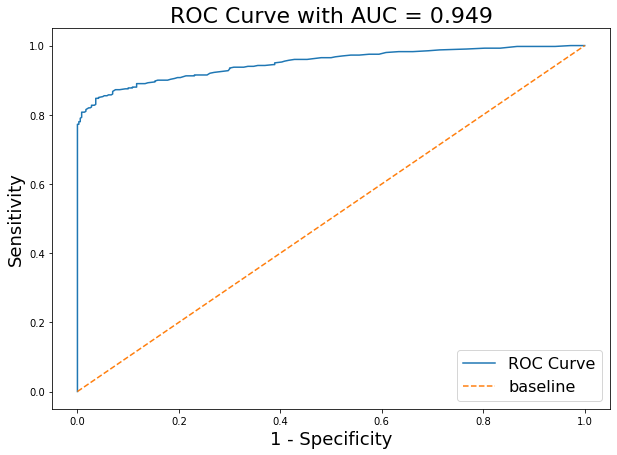

In [656]:
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Baseline Model 

In [658]:
# Baseline accuracy to tell if our model is better than null model
y.value_counts(normalize=True)

1    0.525831
0    0.474169
Name: target, dtype: float64